In [1]:
def get_wikis():
    # data frame instance for storing each row
    dataFrame = pd.DataFrame(columns=['id', 'title', 'content'])
    
    # looping for fetching all available wikis fron DB
    # manually tested for max ranges of limit & offeset,
    # came out to be limit = 50 & offeset = 1337
    for offset in range(0,1340,50):
        # graphql db url for everpedia wikis
        url = "https://graph.everipedia.org/graphql"
        # payload 
        query = """{
                      wikis(limit:50,offset:"""+str(offset)+""") {
                      id
                      title
                      content
                    }
                }"""
        
        # sending request
        response = requests.post(url=url,json={"query":query})
        #time.sleep(0.5)
        # storing newly fetched data into a data frame
        freshDf = pd.DataFrame(response.json()['data']['wikis'])
        
        # concatenating both old & new dataframes as one
        dataFrame = pd.concat([dataFrame, freshDf],axis=0,ignore_index=True)
        
    # DB may return same wiki multiple times from each request, so drop duplicates if any  
    dataFrame = dataFrame.drop_duplicates(subset=['id']) # id is the unique identifier
    
    return dataFrame

In [2]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import requests
import time

In [4]:
df = get_wikis()

In [5]:
df

,id,title,content
0,yi-he,Yi He,"**Yi He** is a Chinese entrepreneur, and inves..."
1,arbitrum-arb,Arbitrum (ARB),**ARB** is the native governance token of [Arb...
2,comp,COMP,**COMP** is an [ERC-20](https://iq.wiki/wiki/e...
3,compound,Compound,**Compound** is a [DeFi](https://iq.wiki/wiki/...
4,dogecoin,Dogecoin,"**Dogecoin** is a peer-to-peer, open-source [c..."
...,...,...,...
1345,ddex,DDEX,DDEX.io is the first Decentralized Exchange (D...
1346,chibi-dinos,Chibi Dinos,"Chibi Dinos are ten thousand (10,000) cute NFT..."
1347,bulls-on-the-block,Bulls on the Block,Bulls on the Block is a Non-Fungible Tokens (N...
1348,bryan-brinkman,Bryan Brinkman,Bryan Brinkman is a cartoon animator from the ...


In [6]:
df.rename(columns={df.columns[0]: 'wikiid'}, inplace=True)

In [7]:
import re
from typing import List

HEADING_REGEX = re.compile(r'^#+ .*$')
WIDGET_REGEX = re.compile(r'^\$\$widget\d(.*?\))\$\$$')
MARKDOWN_LINK_REGEX = re.compile(r'^\[(.*)\]\(.*\)$')
MARKDOWN_IMAGE_REGEX = re.compile(r'^!\[.*\]\(.*\)$')
CITATION_REGEX = re.compile(r'\[\\\[\d+\\\]\]\(#cite-id-[a-z0-9]+\)', flags=re.MULTILINE)

MAX_PARA_COUNT = 3
MAX_CONTENT_LENGTH = 10000


def sanitize_content(content: str) -> str:
    
    """
    This function takes a string `content` that represents a Markdown document.
    It splits the document into paragraphs, filters out any paragraphs that do
    not contain valid text, removes Markdown syntax from the remaining paragraphs,
    and joins them back together into a string. The resulting string is trimmed
    to a maximum length and returned.
    """
        
    content_paragraphs = content.split('\n\n')
    filtered_paragraphs = [
        p for p in content_paragraphs if is_valid_paragraph(p)
    ]
    sanitized_paragraphs = []
    count = 0

    for paragraph in filtered_paragraphs:
        if count >= MAX_PARA_COUNT:
            break

        trimmed_paragraph = paragraph.strip()
        plain_text_paragraph = remove_markdown_syntax(trimmed_paragraph)
        sanitized_paragraph = CITATION_REGEX.sub('', plain_text_paragraph)
        is_heading = HEADING_REGEX.match(trimmed_paragraph) is not None

        if not is_heading:
            sanitized_paragraphs.append(sanitized_paragraph)
            count += 1
        else:
            sanitized_paragraphs.append(trimmed_paragraph)

    trimmed_content = '\n\n'.join(sanitized_paragraphs)[:MAX_CONTENT_LENGTH]

    return trimmed_content


def is_valid_paragraph(paragraph: str) -> bool:
    """
    This function takes a string `paragraph` and checks if it is a valid
    paragraph. A valid paragraph is one that contains text (i.e., is not empty),
    and does not contain Markdown image syntax, link syntax, or widget syntax.
    """
        
    para = paragraph.strip()
    return (
        len(para) != 0
        and not MARKDOWN_IMAGE_REGEX.match(para)
        and not MARKDOWN_LINK_REGEX.match(para)
        and not WIDGET_REGEX.match(para)
    )


def remove_markdown_syntax(text: str) -> str:
    
    """
    This function takes a string `paragraph` and checks if it is a valid
    paragraph. A valid paragraph is one that contains text (i.e., is not empty),
    and does not contain Markdown image syntax, link syntax, or widget syntax.
    """
        
    # Remove emphasis syntax
    text = re.sub(r'\*\*?(.*?)\*\*?', r'\1', text)
    text = re.sub(r'__(.*?)__', r'\1', text)

    # Remove code syntax
    text = re.sub(r'`(.+?)`', r'\1', text)

    # Remove links
    text = re.sub(r'\[(.*?)\]\((.*?)\)', r'\1', text)

    # Remove images
    text = re.sub(r'!\[(.*?)\]\((.*?)\)', r'', text)

    return text

def clean(string):
    sample = string

    cleaned = re.sub(r'\xa0',' ',
                    re.sub(r'\s{2,}',' ',
                       re.sub(r'\>','',
                              re.sub(r'\$\$widget0 YOUTUBE@VID\$\$','',
                                    re.sub(r'[#*]+','',
                                          re.sub(r'\\\[\d+\\\]','',
                                                sample))))))
    return cleaned

In [8]:
df.content = df.content.apply(sanitize_content)
df.content = df.content.apply(clean)
df.head()

,wikiid,title,content
0,yi-he,Yi He,"Yi He is a Chinese entrepreneur, and investor ..."
1,arbitrum-arb,Arbitrum (ARB),ARB is the native governance token of Arbitrum...
2,comp,COMP,COMP is an ERC-20 token that enables community...
3,compound,Compound,Compound is a DeFi project that enables users ...
4,dogecoin,Dogecoin,"Dogecoin is a peer-to-peer, open-source crypto..."


In [9]:
df.iloc[0, 2]

'Yi He is a Chinese entrepreneur, and investor best known for founding Binance , the world\'s largest cryptocurrency exchange, with Changpeng Zhao. She serves as the company\'s Chief Marketing Officer leading business, marketing, and branding strategy at Binance. She was previously a co-founder of the cryptocurrency exchange, OKX, and also served as Vice president for the leading mobile video tech company, Yixia Technology. Early Life & Education Yi He was born in 1986 in China. She grew up in a rural area in Sichuan province in western China, where her parents worked as teachers. She said in an interview with a new media company: “I\'m from a very small village and a very poor family,” But there is not much information available about her early life and education. Yi He, who used to be a travel TV host, hosted \'Beautiful Destination\' and \'As Far As You Can Go\', two of people\'s favorite travel programs. She is also a member of the "Only You《Chinese：非你莫属》" BOSS group. She is popula

In [10]:
!pip install -qU langchain tiktoken matplotlib seaborn tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.1/489.1 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 KB 6.1 MB/s eta 0:00:00


In [11]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

In [13]:
# Applying the tiktoken_len function to the content column and storing results in a list
token_lengths = [tiktoken_len(content) for content in df['content']]

# Calculate min, max, and average token lengths
min_token_length = min(token_lengths)
max_token_length = max(token_lengths)
average_token_length = sum(token_lengths) / len(token_lengths)

print(f"Minimum token length: {min_token_length}")
print(f"Maximum token length: {max_token_length}")
print(f"Average token length: {average_token_length}")

Minimum token length: 126
Maximum token length: 2371
Average token length: 1042.345185185185


In [14]:
# Applying the tiktoken_len function to the content column and storing results in a list
token_lengths = [tiktoken_len(content) for content in df['content']]

# Calculate min, max, and average token lengths
min_token_length = min(token_lengths)
max_token_length = max(token_lengths)
average_token_length = sum(token_lengths) / len(token_lengths)

print(f"Minimum token length: {min_token_length}")
print(f"Maximum token length: {max_token_length}")
print(f"Average token length: {average_token_length}")

Minimum token length: 126
Maximum token length: 2371
Average token length: 1042.345185185185


In [28]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=150,
    chunk_overlap=40,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['.', '']
)

In [29]:
df['chunks'] = df['content'].apply(text_splitter.split_text)

In [30]:
# Explode the chunks list into individual rows, copying the wikiid and title values
df_exploded = df.explode('chunks').reset_index(drop=True)
df_exploded = df_exploded[['wikiid', 'title', 'chunks']]

In [31]:
df_exploded

,wikiid,title,chunks
0,yi-he,Yi He,"Yi He is a Chinese entrepreneur, and investor ..."
1,yi-he,Yi He,Early Life & Education Yi He was born in 1986 ...
2,yi-he,Yi He,"She is also a member of the ""Only You《Chinese：..."
3,yi-he,Yi He,She joined the Chinese Television Channel in 2...
4,yi-he,Yi He,Yi He responsibly handled user operations mana...
...,...,...,...
13596,bryan-brinkman,Bryan Brinkman,Bryan Brinkman is a cartoon animator from the ...
13597,bryan-brinkman,Bryan Brinkman,"Guests on the show including Russell Brand, Al..."
13598,bold-badgers-squad,Bold Badgers Squad,"Bold Badgers Squad is a collection of 10,000 u..."
13599,bold-badgers-squad,Bold Badgers Squad,Roadmap Phase 0 Release the BADGERS: On August...


In [33]:
df_exploded.iloc[100, 2]

"The animations' fluid motion model is based on academic research conducted in 2010, while the struck percussion sounds are synthesized using shared physical principles. This series builds on the user-programmable media approach of Series 4, with one token designated for community access. While unowned, this token provides communal utility for members to learn, study, and interact with a programmable system, including changing parameters that influence the audiovisual output. All changes and their authors' addresses are stored immutably on-chain. Remarkably, the audiovisual outputs are entirely reconstructed from 100kb of self-contained C code stored on-chain. The most expensive piece traded for 107 ETH."

In [34]:
# Applying the tiktoken_len function to the content column and storing results in a list
token_lengths = [tiktoken_len(content) for content in df_exploded['chunks']]

# Calculate min, max, and average token lengths
min_token_length = min(token_lengths)
max_token_length = max(token_lengths)
average_token_length = sum(token_lengths) / len(token_lengths)

print(f"Minimum token length: {min_token_length}")
print(f"Maximum token length: {max_token_length}")
print(f"Average token length: {average_token_length}")

Minimum token length: 1
Maximum token length: 152
Average token length: 124.77141386662746


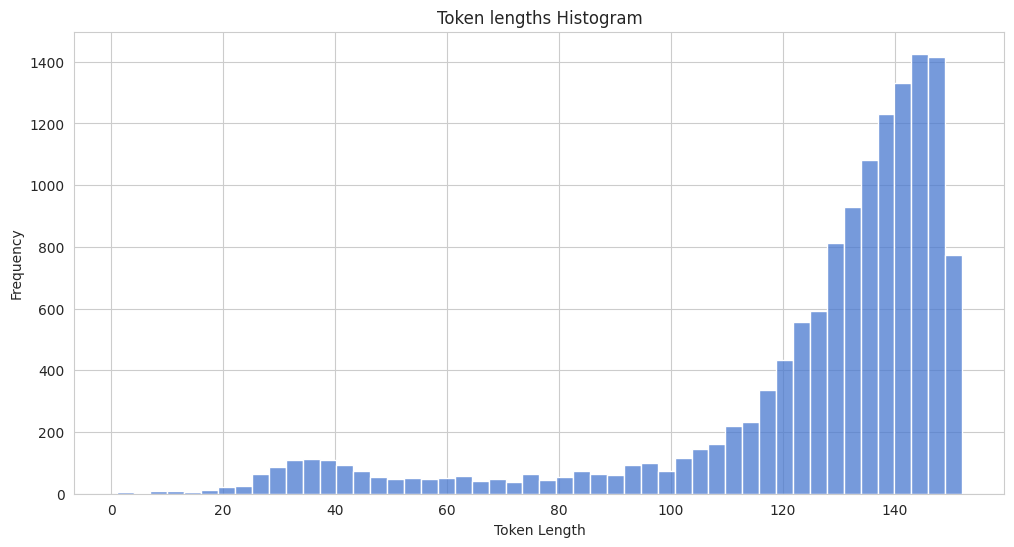

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_lengths, kde=False, bins=50)

# customize the plot info
plt.title("Token lengths Histogram")
plt.xlabel("Token Length")
plt.ylabel("Frequency")

plt.show()

In [36]:
!pip install supabase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.4/134.4 KB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.4/216.4 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [37]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 KB 3.5 MB/s eta 0:00:00


In [38]:
import os
import openai
from getpass import getpass

openai.api_key = getpass()

··········


In [39]:
import numpy as np
import supabase
supabase_url = 'https://wpisaiqtaoykjwwszlan.supabase.co'
supabase_key = 'PRIVATE'
supabase_client = supabase.Client(supabase_url, supabase_key)

In [40]:
def get_embedding(text, engine="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=engine)['data'][0]['embedding']

In [41]:
for i in range(0, 13601):
    embeddings = get_embedding(df_exploded.iloc[i,2])
    supabase_client.table("langchain_150tkn").insert({"wikiid":df_exploded.iloc[i,0], "title": df_exploded.iloc[i,1], "content": df_exploded.iloc[i,2], "embedding": embeddings }).execute()